# Prepare WiFi Data for GDN
GDN is an unsupervised anomaly detection algorithm that identifies anomalies at a timestep level for an entire system. This system consists of nodes that generate time-series (such as sensors in a water treatment plant), and GDN learns the relationship between the nodes during non-anomalous operation. These learned relationships can then be used at inference time to identify if the system is operating with anomalies.

To use GDN, we need a text file containing the list of nodes (will be referred to as 'sensors'), a train CSV containing timesteps and time series with for each sensor, and a test CSV containing timesteps and time series for each sensor, and labels for each time step.


This notebook prepares the wifi data and constructs the necessary train, test, and list.txt files for GDN

## Table of Contents  

    Imports
    Understanding the Data
    Setup  
    Data Cleaning  
    Exploratory Data Analysis of Cleaned Data  
    Assigning "Attack" Labels
    Normalizing Data
    Saving Cleaned Data for GDN  

## Imports

In [1]:
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import random
import pathlib
from sklearn.preprocessing import MinMaxScaler

## Understanding the Data
 
Despite the growing popularity of 802.11 wireless networks, users often suffer from connectivity problems and performance issues due to unstable radio conditions and dynamic user behavior among other reasons. Anomaly detection and distinction are in the thick of major challenges that network managers encounter. This dataset exploits simulation as an effective tool to setup a computationally tractable network. 

The data features are categorized in two main classes: Density Attributes and Usage Attributes.   
1. Density Attributes demonstrate how crowded is the place in terms of active attendant users, characterizing the association population and durability,
2. Usage Attributes disclose the volume of the sent and received traffics by the present users, revealing the total bandwidth throughput regardless of how populous is the place and it is more relevant to the applications utilized by the current mobile users.

We take a look at the usage attributes for subpopulation Net 1 and Net2. Net1 represents a subpopulation with normal behavior, and Net2 contains anomalies. We try to use graph based anomaly detection approaches to accurately identify the anomalies in Net2. 


## Setup Instructions
1. Prepare GDN framework:   
    run `prepare_gdn_environment.sh`
2. Download wifi dataset  
  - option 1: Automatic
    - navigate to `../download_data.ipynb` and run the "For telecom anomaly" cells"
  - option 2: Manually
    - create cleaned_data folder within `../../data/03_primary/wifi`
    - download link: [github link](https://github.com/dpernes/spamhmm/blob/master/README.md) [wifi dataset download link](https://drive.google.com/file/d/1IyK8lWvV9bDQ43ZT6a51lB9iPT9EtXt8/view)   
  - untar data within `../../data/03_primary/wifi` folder: ` tar -xzvf wifi_data.tar.gz`
4. GDN requires the following files:  
    **list.txt:** the feature names, one feature per line  
    **train.csv:** training data modeling normal behavior, no anomalies were present according to the paper  
    **test.csv:** test data.test.csv should have a column named "attack" which contains ground truth label(0/1) of being attacked or not(0: normal, 1:
    attacked)  

This notebook creates the 3 files mentioned above and will save them in `../../data/03_primary/wifi`

## Data Cleaning

Currently, in each Net, each subpopulation contains a UDP directory, containing a sent and received csv for each of the 100 users. Currently, the raw data has a time column and a column formatted `Net2.cliHostx[y].udp.sentPk:vector(packetBytes)` where `y` represents the host. We want to clean the column names to only include the host name and round the time values to the nearest second. This is an example of one of the tables: 


| time      | Net2.cliHostx[y].udp.sentPk:vector(packetBytes) |
| ----------- | ----------- |
| 1.15      | 100       |
| 63.2   | 231        |


In order to run any graph based anomaly detection technique, we need a complete time series dataset. the UDP data is incomplete. Each file represents a user, who is either sending or receiving packets. Per subpopulation, there are 100 users, both sending and receiving packets -- 200 csv files. Within each of these files, we have a time column and a value columm, representing number of packets (in bytes) sent/received.

We to fill in the missing time values with 0's since no bytes were either sent or received at that time. This will give us a more complete time series dataset. We want to sum the values for each host. For example, if host 8 received 10 bytes from user 3 and 12 bytes from user 4 at time t, then the value for time t should be 22. Finally, we want to concatenate the datasets to have one large dataset, with the time as index, and the hosts as column names or sensors. We need both a test and a train dataset for GDN. The train data will be from Net1 (normal behavior) and the test data will come from Net 2 (containing anomalies)

In [2]:
def clean_host_data(udp_subpopulation_data_path, sent=False):
    all_nums = []
    host_user_map = {}
    maximum_time = get_maximum_time(udp_subpopulation_data_path)
    all_data = []
    filename_prefix_check = 'r'
    if sent:
        filename_prefix_check = 's'
        
    for csv in os.listdir(net2_sub_0_path):
        if csv[0]==filename_prefix_check:
            try: 
                df = pd.read_csv(udp_subpopulation_data_path + csv)
                host_column = df.columns[1]
                host = int(host_column.split("[")[1].split("]")[0])
                df.set_axis(['time', str(host)], axis=1, inplace=True)

                if host not in host_user_map:
                    host_user_map[host] = []
                host_user_map[host].append(csv)
                time_value_map = contruct_time_value_map(df)
                column_values = fill_time_gaps(df, time_value_map, maximum_time)
                df = impute_data(df, maximum_time, column_values)
                all_data.append(df)
            except:
                print("cannot load file: ", csv)
                pass
    return all_data
        
def get_maximum_time(udp_subpopulation_data_path):
    maximum_time = 0
    for csv in os.listdir(udp_subpopulation_data_path):
        try:
            df = pd.read_csv(udp_subpopulation_data_path + csv)
            df = df.round({"time":0})
            maximum_time =max(max(df["time"]), maximum_time)
        except:
            print("cannot load file:   ", csv)    
    return maximum_time

def contruct_time_value_map(df):
    host = df.columns[1]
    time_value_map = {}
    for index, row in df.iterrows():
        time_value_map[int(row["time"])] = row[host]
    return time_value_map

def fill_time_gaps(df, time_value_map, maximum_time):
    column_values = []
    for t in range(int(maximum_time)):
        if t+1 in time_value_map:
            column_values.append(time_value_map[t+1])
        else:
            column_values.append(0)
    return column_values

def impute_data(df, maximum_time, column_values):
    time = [i+1for i in range(int(maximum_time))]
    host = df.columns[1]
    df = pd.DataFrame(data={"time": [i+1for i in range(int(maximum_time))], host: column_values})
    return df

def reconstruct_dataset(maximum_time, udp_subpopulation_data_path, output_path=""):
    print("here")
    for csv in os.listdir(udp_subpopulation_data_path):
        try:
            df = pd.read_csv(udp_subpopulation_data_path + csv)
            time_value_map = contruct_time_value_map(df)
            column_values = fill_time_gaps(df, time_value_map, maximum_time)
            df = impute_data(df, maximum_time, column_values)
            df.to_csv(output_path + csv, index=False)
        except:
            print("cannot load file:   ", csv)
            

def construct_dataset_aggregate_hosts(all_host_data):
    data = {}
    for df in all_host_data:
        host = df.columns[1]
        if host in data:
            aggregate_packets = data[host] + df[host]
            data[host] = aggregate_packets
        else:
            data[host] = df[host]

    return pd.DataFrame(data=data)
            

In [3]:
# Net2 sent and received dataframes
net2_sub_0_path = "../../data/01_raw/wifi/wifi_data/Net2/0/UDP/"
net2_cleaned_sent_dfs = clean_host_data(net2_sub_0_path, sent=True)
net2_cleaned_rcvd_dfs = clean_host_data(net2_sub_0_path, sent=False)

In [4]:
net2_cleaned_sent_dfs[0].columns

Index(['time', '15'], dtype='object')

In [6]:
# Net1 sent and received dataframes
net1_sub_0_path ="../../data/01_raw/wifi/wifi_data/Net1/0/UDP/"
net1_cleaned_sent_dfs = clean_host_data(net1_sub_0_path, sent=True)
net1_cleaned_rcvd_dfs = clean_host_data(net1_sub_0_path, sent=False)

In [7]:
net1_cleaned_sent_dfs[0].columns

Index(['time', '15'], dtype='object')

We summed packets from the same hosts. We must do this for both sent and received files. First we aggregate the received (rcvd) files then the sent files. We will then get the sent - received values for each host.

In [8]:
net1_sent_aggregated_df = construct_dataset_aggregate_hosts(net1_cleaned_sent_dfs)
net1_sent_aggregated_df.head()

,15,26,19,9,13,17,1,5,0,4,...,25,16,11,20,27,22,28,29,21,23
0,161.0,0.0,44.0,475.0,197.0,229.0,532.0,400.0,486.0,376.0,...,0.0,162.0,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,210.0,0.0,170.0,397.0,185.0,289.0,437.0,318.0,339.0,314.0,...,0.0,226.0,141.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,191.0,0.0,209.0,330.0,151.0,200.0,382.0,439.0,486.0,285.0,...,0.0,345.0,192.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,125.0,0.0,278.0,437.0,223.0,163.0,454.0,374.0,337.0,358.0,...,0.0,178.0,175.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,199.0,0.0,243.0,411.0,149.0,227.0,550.0,766.0,359.0,348.0,...,0.0,157.0,214.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
net1_rcvd_aggregated_df = construct_dataset_aggregate_hosts(net1_cleaned_rcvd_dfs)
net1_rcvd_aggregated_df.head()

,1,10,6,25,7,17,2,12,4,9,...,15,3,11,16,21,13,29,23,24,26
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,272.0,0.0,276.0,0.0,242.0,0.0,214.0,298.0,0.0,411.0,...,0.0,0.0,0.0,0.0,0.0,149.0,0.0,0.0,0.0,0.0


In [10]:
net2_sent_aggregated_df = construct_dataset_aggregate_hosts(net2_cleaned_sent_dfs)
net2_rcvd_aggregated_df = construct_dataset_aggregate_hosts(net2_cleaned_rcvd_dfs)

net2_sent_aggregated_df.head()

,15,26,19,9,13,17,1,5,0,4,...,25,16,11,20,27,22,28,29,21,23
0,161.0,0.0,44.0,475.0,197.0,229.0,532.0,400.0,486.0,376.0,...,0.0,162.0,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,210.0,0.0,170.0,397.0,185.0,289.0,437.0,318.0,339.0,314.0,...,0.0,226.0,141.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,191.0,0.0,209.0,330.0,151.0,200.0,382.0,439.0,486.0,285.0,...,0.0,345.0,192.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,125.0,0.0,278.0,437.0,223.0,163.0,454.0,374.0,337.0,358.0,...,0.0,178.0,175.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,199.0,0.0,243.0,411.0,149.0,227.0,550.0,766.0,359.0,348.0,...,0.0,157.0,214.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
net2_rcvd_aggregated_df.head()

,1,9,4,29,7,0,2,12,8,10,...,27,16,25,18,15,23,13,26,21,24
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,432.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,272.0,411.0,0.0,0.0,242.0,423.0,214.0,298.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,149.0,0.0,0.0,0.0


## Exploratory Data Analysis of Cleaned Data  

In [12]:
net1_sent_df_hosts = set(net1_sent_aggregated_df.columns)
net1_rcvd_df_hosts  = set(net1_rcvd_aggregated_df.columns)
net1_rcvd_df_hosts == net1_sent_df_hosts

True

In [13]:
net2_sent_df_hosts = set(net2_sent_aggregated_df.columns)
net2_rcvd_df_hosts  = set(net2_rcvd_aggregated_df.columns)
net2_rcvd_df_hosts == net2_sent_df_hosts

#verifying the hosts are the same
net2_rcvd_df_hosts == net2_sent_df_hosts

True

We subtract the received bytes from the sent bytes. Ideally, the same number of packets sent, should also be received. Understanding the number of leftover packets will help us understand the data and aggregate it into one dataset in a meaningful way. 

In [14]:
def subtract_received_from_sent(sent_df, rcvd_df):
    sent_minus_received = {}
    for host in sent_df:
        sent_minus_received[host]=sent_df[host] - rcvd_df[host]
    df = pd.DataFrame(data=sent_minus_received)
    return df

In [15]:
net1_subtracted_data = subtract_received_from_sent(net1_sent_aggregated_df, net1_rcvd_aggregated_df)
net2_subtracted_data = subtract_received_from_sent(net2_sent_aggregated_df, net2_rcvd_aggregated_df)

In [16]:
net2_subtracted_data.head()

,15,26,19,9,13,17,1,5,0,4,...,25,16,11,20,27,22,28,29,21,23
0,161.0,0.0,44.0,475.0,197.0,229.0,532.0,400.0,486.0,376.0,...,0.0,162.0,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,210.0,0.0,170.0,397.0,185.0,289.0,437.0,318.0,339.0,314.0,...,0.0,226.0,141.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,191.0,0.0,209.0,330.0,151.0,200.0,382.0,439.0,486.0,285.0,...,0.0,345.0,192.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,125.0,0.0,278.0,437.0,223.0,163.0,454.0,374.0,-95.0,358.0,...,0.0,178.0,175.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,199.0,0.0,243.0,0.0,0.0,227.0,278.0,590.0,-64.0,348.0,...,0.0,157.0,214.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
net1_subtracted_data.head()

,15,26,19,9,13,17,1,5,0,4,...,25,16,11,20,27,22,28,29,21,23
0,161.0,0.0,44.0,475.0,197.0,229.0,532.0,400.0,486.0,376.0,...,0.0,162.0,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,210.0,0.0,170.0,397.0,185.0,289.0,437.0,318.0,339.0,314.0,...,0.0,226.0,141.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,191.0,0.0,209.0,330.0,151.0,200.0,382.0,439.0,486.0,285.0,...,0.0,345.0,192.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,125.0,0.0,278.0,437.0,223.0,163.0,454.0,374.0,-95.0,358.0,...,0.0,178.0,175.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,199.0,0.0,243.0,0.0,0.0,227.0,278.0,590.0,-64.0,348.0,...,0.0,157.0,214.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
column_names = net1_subtracted_data.columns
column_names

Index(['15', '26', '19', '9', '13', '17', '1', '5', '0', '4', '18', '12', '6',
       '8', '7', '14', '2', '3', '10', '24', '25', '16', '11', '20', '27',
       '22', '28', '29', '21', '23'],
      dtype='object')

In [19]:
# Keeping only the first 1200 rows, 1200 seconds so the normal behavior and anomaly data are the same length
net1_subtracted_data=net1_subtracted_data.head(1200)
len(net1_subtracted_data)

1200

In [20]:
len(net2_subtracted_data)

1200

Plotting number of packets per host, overlaying the anomaly data and the normal data to see if we can visualize anomalies

In [21]:
def plot_num_packets(net1, net2, host):
    fig = plt.figure(figsize=(15, 10))
    time = [i for i in range(1200)]
    plt.scatter(time, net2[host], alpha = 0.3, label="Anomaly Net2")
    plt.scatter(time, net1[host], alpha=0.3, color = "orange", label= "Normal Behavior Net1")
    title = "Number of Packets Host: " + host
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Number of Packets Sent- Received ")
    plt.legend()

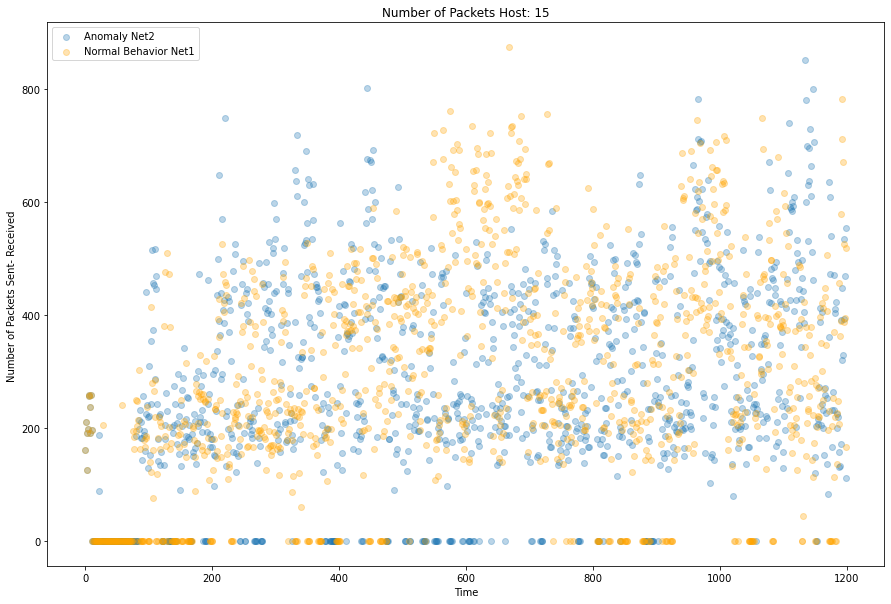

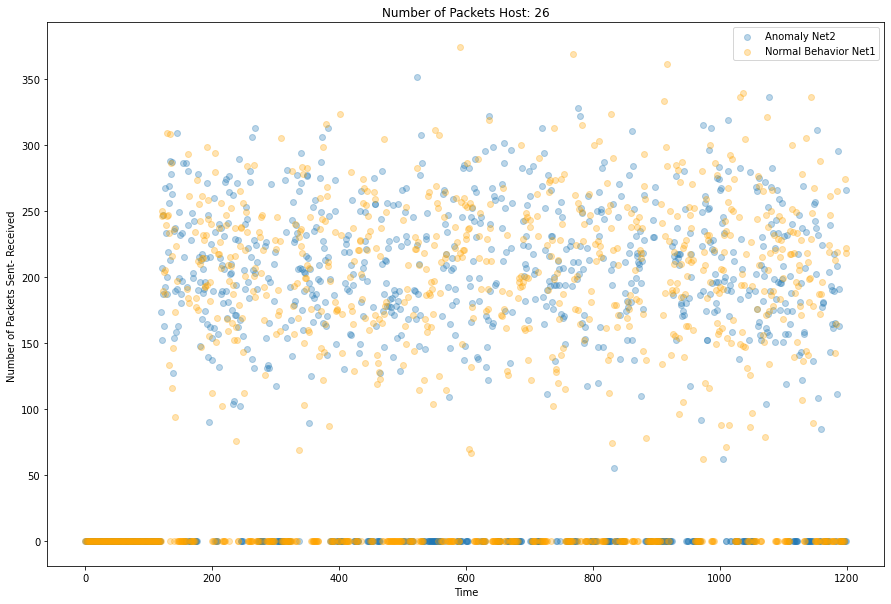

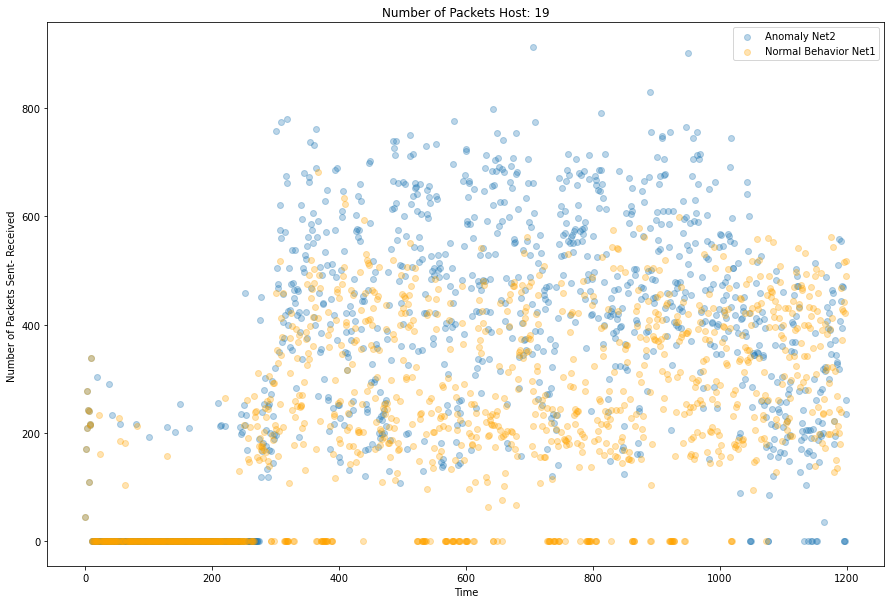

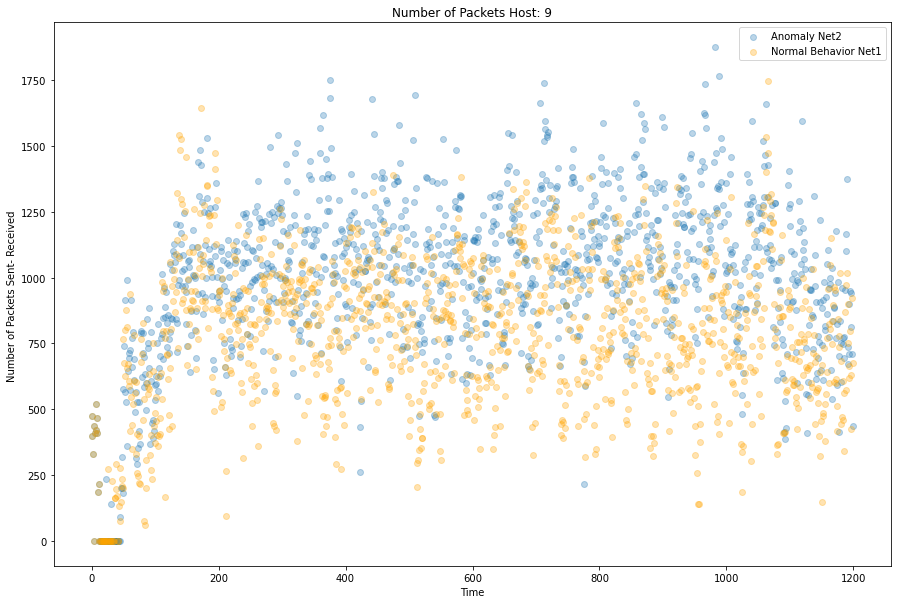

In [22]:
for host in column_names[:4]:
    plot_num_packets(net1_subtracted_data, net2_subtracted_data, host)

## Assigning "Attack" Labels

In [23]:
net2_subtracted_data.columns

Index(['15', '26', '19', '9', '13', '17', '1', '5', '0', '4', '18', '12', '6',
       '8', '7', '14', '2', '3', '10', '24', '25', '16', '11', '20', '27',
       '22', '28', '29', '21', '23'],
      dtype='object')

In [24]:
net2_subtracted_data.head(n=5)

,15,26,19,9,13,17,1,5,0,4,...,25,16,11,20,27,22,28,29,21,23
0,161.0,0.0,44.0,475.0,197.0,229.0,532.0,400.0,486.0,376.0,...,0.0,162.0,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,210.0,0.0,170.0,397.0,185.0,289.0,437.0,318.0,339.0,314.0,...,0.0,226.0,141.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,191.0,0.0,209.0,330.0,151.0,200.0,382.0,439.0,486.0,285.0,...,0.0,345.0,192.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,125.0,0.0,278.0,437.0,223.0,163.0,454.0,374.0,-95.0,358.0,...,0.0,178.0,175.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,199.0,0.0,243.0,0.0,0.0,227.0,278.0,590.0,-64.0,348.0,...,0.0,157.0,214.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


To assign attack labels, we will subtract the packets for the normal and anomaly data.  
0: [2*Lower Quartile, 2*Upper Quartile]  
1: otherwise  

In [25]:
def assign_attack_labels(normal_data, 
                         anomaly_data):
    all_data = {}
    for host in normal_data.columns:
        all_data[host] =  abs(normal_data[host]-anomaly_data[host])
    all_data = pd.DataFrame(all_data)
    
    
    all_host_stats = {}
    for host in all_data.columns:
        host_data = dict(all_data[host].describe())
        all_host_stats[host]=host_data
        
    all_host_stats
    anomaly_times = set()
    for host in all_data.columns:
        min_accepted_value = -2*all_host_stats[host]["25%"]
        max_accepted_value =  2*all_host_stats[host]["75%"]
        for index, row in all_data.iterrows():
            value = row[host]
            if (value < min_accepted_value or value > max_accepted_value) and (int(value) != 0):
                anomaly_times.add(index)
                
    anomaly_data["attack"] = [0 for i in range(len(anomaly_data))]
    for index, row in anomaly_data.iterrows():
        if index in anomaly_times:
            anomaly_data["attack"][index]= 1
    return anomaly_data, anomaly_times


In [26]:
net2_with_labels, anomaly_times = assign_attack_labels(net1_subtracted_data, net2_subtracted_data)

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [27]:
net2_with_labels

,15,26,19,9,13,17,1,5,0,4,...,16,11,20,27,22,28,29,21,23,attack
0,161.0,0.0,44.0,475.0,197.0,229.0,532.0,400.0,486.0,376.0,...,162.0,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,210.0,0.0,170.0,397.0,185.0,289.0,437.0,318.0,339.0,314.0,...,226.0,141.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,191.0,0.0,209.0,330.0,151.0,200.0,382.0,439.0,486.0,285.0,...,345.0,192.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,125.0,0.0,278.0,437.0,223.0,163.0,454.0,374.0,-95.0,358.0,...,178.0,175.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,199.0,0.0,243.0,0.0,0.0,227.0,278.0,590.0,-64.0,348.0,...,157.0,214.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,534.0,0.0,0.0,948.0,206.0,342.0,1203.0,677.0,591.0,801.0,...,403.0,231.0,0.0,309.0,199.0,0.0,222.0,312.0,239.0,0
1196,393.0,0.0,0.0,941.0,138.0,405.0,796.0,565.0,570.0,1034.0,...,353.0,214.0,0.0,245.0,166.0,0.0,0.0,225.0,0.0,0
1197,469.0,0.0,0.0,813.0,176.0,416.0,916.0,726.0,998.0,864.0,...,488.0,312.0,0.0,202.0,218.0,0.0,0.0,306.0,0.0,0
1198,554.0,266.0,261.0,708.0,196.0,231.0,1073.0,457.0,815.0,1313.0,...,487.0,173.0,0.0,242.0,277.0,0.0,0.0,175.0,265.0,0


In [28]:
# Notice how there are no zeros in the anomaly times
print(sorted(list(anomaly_times)))

[52, 69, 71, 74, 77, 80, 81, 86, 90, 103, 115, 123, 124, 128, 130, 134, 136, 138, 139, 148, 150, 151, 153, 154, 155, 157, 161, 171, 177, 179, 181, 183, 193, 196, 197, 199, 200, 203, 206, 208, 209, 210, 212, 213, 214, 215, 216, 218, 219, 220, 221, 222, 226, 227, 231, 233, 234, 236, 237, 238, 242, 244, 251, 252, 254, 256, 260, 262, 268, 274, 275, 278, 283, 287, 289, 295, 311, 316, 317, 318, 322, 326, 330, 331, 332, 333, 336, 338, 340, 341, 342, 344, 347, 351, 352, 358, 359, 362, 363, 364, 365, 366, 368, 369, 370, 375, 376, 378, 379, 380, 381, 382, 383, 386, 387, 390, 400, 401, 404, 405, 412, 414, 415, 416, 418, 424, 444, 445, 447, 449, 454, 456, 457, 463, 470, 471, 472, 475, 480, 481, 488, 489, 496, 497, 502, 503, 507, 509, 510, 515, 516, 522, 523, 528, 529, 534, 543, 551, 552, 556, 561, 565, 567, 568, 570, 571, 572, 573, 574, 575, 576, 577, 578, 580, 581, 585, 589, 594, 598, 599, 600, 603, 604, 605, 607, 611, 612, 613, 615, 617, 620, 621, 622, 624, 628, 630, 633, 634, 638, 639, 640, 641

In [29]:
# Fraction of data classified as anomalies
len(anomaly_times)/1200

0.3333333333333333

In [30]:
# Verifying the attack column has been populated properly. Recall, there were 400 anomalies identified from our method above
sum(net2_with_labels["attack"])

400

In [31]:
net2_with_labels.columns

Index(['15', '26', '19', '9', '13', '17', '1', '5', '0', '4', '18', '12', '6',
       '8', '7', '14', '2', '3', '10', '24', '25', '16', '11', '20', '27',
       '22', '28', '29', '21', '23', 'attack'],
      dtype='object')

In [32]:
net2_with_labels.head(4)

,15,26,19,9,13,17,1,5,0,4,...,16,11,20,27,22,28,29,21,23,attack
0,161.0,0.0,44.0,475.0,197.0,229.0,532.0,400.0,486.0,376.0,...,162.0,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,210.0,0.0,170.0,397.0,185.0,289.0,437.0,318.0,339.0,314.0,...,226.0,141.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,191.0,0.0,209.0,330.0,151.0,200.0,382.0,439.0,486.0,285.0,...,345.0,192.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,125.0,0.0,278.0,437.0,223.0,163.0,454.0,374.0,-95.0,358.0,...,178.0,175.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Plotting the number of packets sent - received. This way we can see where the anomalies actually lie. 

In [33]:
def plot_num_packets_overlay_attack(normal, anomaly, host):
    fig = plt.figure(figsize=(15, 10))
    plt.scatter(anomaly.index, anomaly[host], alpha = 0.3, label="Anomaly")
    plt.scatter(normal.index, normal[host], alpha=0.3, color = "orange", label= "Normal Behavior")
    plt.scatter(normal.index, anomaly["attack"], alpha=0.3, color = "red", label= "Classified Anomaly")
    title = "Number of Packets with Highlighted Anomalies Host:  " + host
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Number of Packets Sent-Received")
    plt.legend()

In [34]:
column_names = net2_with_labels.columns[:-1]
column_names

Index(['15', '26', '19', '9', '13', '17', '1', '5', '0', '4', '18', '12', '6',
       '8', '7', '14', '2', '3', '10', '24', '25', '16', '11', '20', '27',
       '22', '28', '29', '21', '23'],
      dtype='object')

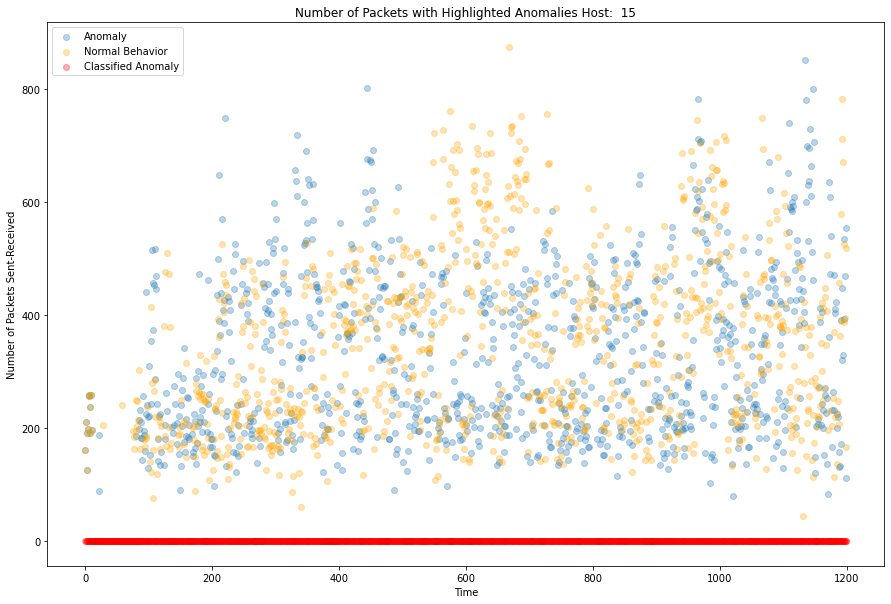

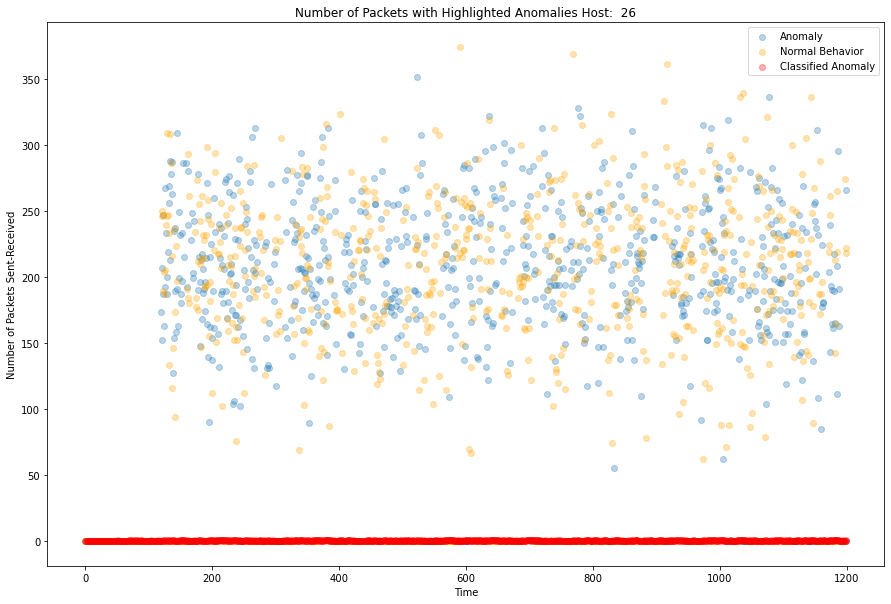

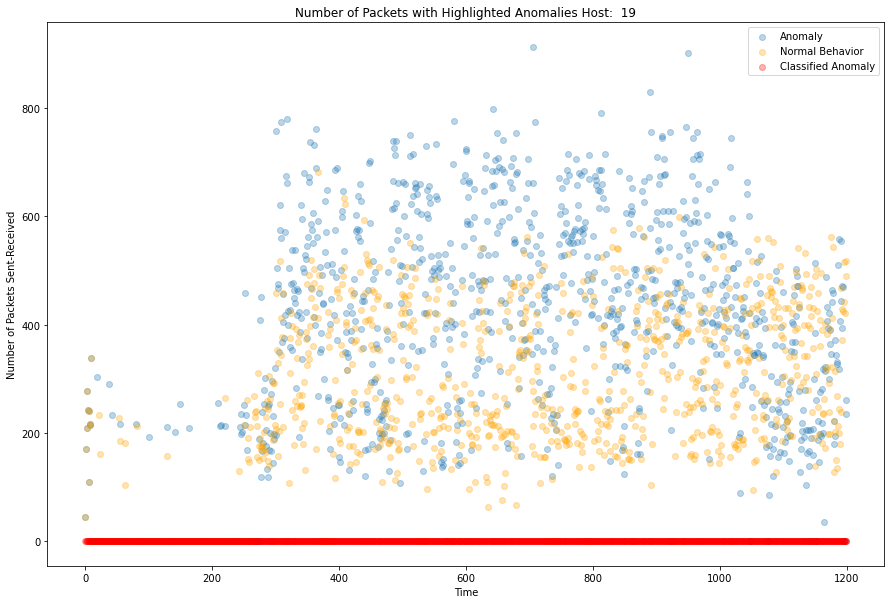

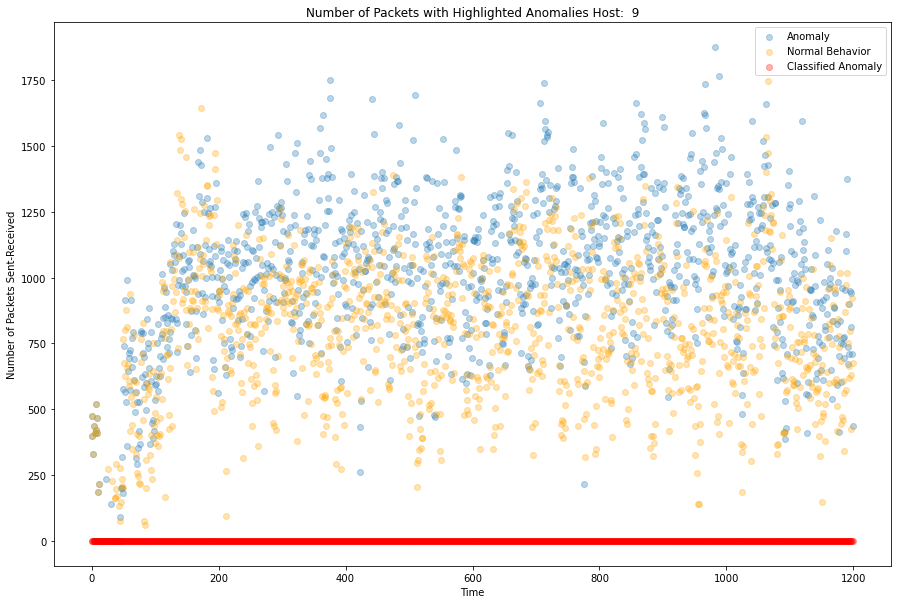

In [35]:
for host in column_names[:4]:
    plot_num_packets_overlay_attack(net1_subtracted_data, net2_with_labels, host)

In [36]:
net1_subtracted_data

,15,26,19,9,13,17,1,5,0,4,...,25,16,11,20,27,22,28,29,21,23
0,161.0,0.0,44.0,475.0,197.0,229.0,532.0,400.0,486.0,376.0,...,0.0,162.0,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,210.0,0.0,170.0,397.0,185.0,289.0,437.0,318.0,339.0,314.0,...,0.0,226.0,141.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,191.0,0.0,209.0,330.0,151.0,200.0,382.0,439.0,486.0,285.0,...,0.0,345.0,192.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,125.0,0.0,278.0,437.0,223.0,163.0,454.0,374.0,-95.0,358.0,...,0.0,178.0,175.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,199.0,0.0,243.0,0.0,0.0,227.0,278.0,590.0,-64.0,348.0,...,0.0,157.0,214.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,526.0,0.0,515.0,796.0,715.0,0.0,1344.0,569.0,528.0,1178.0,...,0.0,224.0,312.0,0.0,236.0,148.0,0.0,0.0,133.0,203.0
1196,387.0,0.0,442.0,630.0,698.0,187.0,1241.0,727.0,614.0,1021.0,...,0.0,264.0,363.0,0.0,198.0,301.0,0.0,0.0,211.0,258.0
1197,395.0,274.0,422.0,425.0,529.0,318.0,1044.0,576.0,623.0,1026.0,...,0.0,119.0,431.0,0.0,316.0,122.0,0.0,182.0,186.0,247.0
1198,167.0,222.0,518.0,921.0,567.0,117.0,1135.0,507.0,468.0,1176.0,...,0.0,498.0,168.0,0.0,226.0,197.0,0.0,204.0,136.0,229.0


In [37]:
net2_with_labels

,15,26,19,9,13,17,1,5,0,4,...,16,11,20,27,22,28,29,21,23,attack
0,161.0,0.0,44.0,475.0,197.0,229.0,532.0,400.0,486.0,376.0,...,162.0,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,210.0,0.0,170.0,397.0,185.0,289.0,437.0,318.0,339.0,314.0,...,226.0,141.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,191.0,0.0,209.0,330.0,151.0,200.0,382.0,439.0,486.0,285.0,...,345.0,192.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,125.0,0.0,278.0,437.0,223.0,163.0,454.0,374.0,-95.0,358.0,...,178.0,175.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,199.0,0.0,243.0,0.0,0.0,227.0,278.0,590.0,-64.0,348.0,...,157.0,214.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,534.0,0.0,0.0,948.0,206.0,342.0,1203.0,677.0,591.0,801.0,...,403.0,231.0,0.0,309.0,199.0,0.0,222.0,312.0,239.0,0
1196,393.0,0.0,0.0,941.0,138.0,405.0,796.0,565.0,570.0,1034.0,...,353.0,214.0,0.0,245.0,166.0,0.0,0.0,225.0,0.0,0
1197,469.0,0.0,0.0,813.0,176.0,416.0,916.0,726.0,998.0,864.0,...,488.0,312.0,0.0,202.0,218.0,0.0,0.0,306.0,0.0,0
1198,554.0,266.0,261.0,708.0,196.0,231.0,1073.0,457.0,815.0,1313.0,...,487.0,173.0,0.0,242.0,277.0,0.0,0.0,175.0,265.0,0


## Normalizing Data

In [38]:
# max min(0-1)
def norm(train, test):
    normalizer = MinMaxScaler(feature_range=(0, 1)).fit(train) # scale training data to [0,1] range
    train_ret = normalizer.transform(train)
    test_ret = normalizer.transform(test)

    return train_ret, test_ret

In [39]:
test = net2_with_labels
train = net1_subtracted_data
attack_column = test["attack"]

test = test.iloc[:, 1:]
train = train.iloc[:, 1:]

train = train.fillna(train.mean())
test = test.fillna(test.mean())
train = train.fillna(0)
test = test.fillna(0)

train_columns = train.columns
test_columns = test.columns

# trim column names
train = train.rename(columns=lambda x: x.strip())
test = test.rename(columns=lambda x: x.strip())

print(len(test.columns),test.columns)
print(len(train.columns),train.columns)


# train_labels = train.attack
test_labels = test.attack

# train = train.drop(columns=['attack'])
test = test.drop(columns=['attack'])


x_train, x_test = norm(train.values, test.values)

30 Index(['26', '19', '9', '13', '17', '1', '5', '0', '4', '18', '12', '6', '8',
       '7', '14', '2', '3', '10', '24', '25', '16', '11', '20', '27', '22',
       '28', '29', '21', '23', 'attack'],
      dtype='object')
29 Index(['26', '19', '9', '13', '17', '1', '5', '0', '4', '18', '12', '6', '8',
       '7', '14', '2', '3', '10', '24', '25', '16', '11', '20', '27', '22',
       '28', '29', '21', '23'],
      dtype='object')


In [40]:
train_df = pd.DataFrame(x_train, columns = train_columns)
test_df =pd.DataFrame(x_test, columns = test_columns[:-1])
train_df.head()

,26,19,9,13,17,1,5,0,4,18,...,25,16,11,20,27,22,28,29,21,23
0,0.0,0.064516,0.272206,0.213434,0.315427,0.325581,0.158044,0.359098,0.077778,0.351410,...,0.0,0.215712,0.340599,0.0,0.0,0.293763,0.197701,0.095855,0.0,0.0
1,0.0,0.249267,0.227507,0.200433,0.398072,0.267442,0.111427,0.299919,0.041520,0.345987,...,0.0,0.300932,0.192098,0.0,0.0,0.293763,0.197701,0.095855,0.0,0.0
2,0.0,0.306452,0.189112,0.163597,0.275482,0.233782,0.180216,0.359098,0.024561,0.232104,...,0.0,0.459387,0.261580,0.0,0.0,0.293763,0.197701,0.095855,0.0,0.0
3,0.0,0.407625,0.250430,0.241603,0.224518,0.277846,0.143263,0.125201,0.067251,0.276573,...,0.0,0.237017,0.238420,0.0,0.0,0.293763,0.197701,0.095855,0.0,0.0
4,0.0,0.356305,0.000000,0.000000,0.312672,0.170135,0.266060,0.137681,0.061404,0.197397,...,0.0,0.209055,0.291553,0.0,0.0,0.293763,0.197701,0.095855,0.0,0.0


## Saving Cleaned Data for GDN  

In [41]:
test_df["attack"] = attack_column

In [42]:
def descriptive_column_names(df):
    new_column_names = {}
    for column in df.columns:
        if column != "attack":
            new_column_names[column] = "host_"+column
    return new_column_names

In [43]:
train_df.rename(columns=descriptive_column_names(train_df), inplace=True)
test_df.rename(columns=descriptive_column_names(test_df), inplace=True)

In [44]:
test_df.columns

Index(['host_26', 'host_19', 'host_9', 'host_13', 'host_17', 'host_1',
       'host_5', 'host_0', 'host_4', 'host_18', 'host_12', 'host_6', 'host_8',
       'host_7', 'host_14', 'host_2', 'host_3', 'host_10', 'host_24',
       'host_25', 'host_16', 'host_11', 'host_20', 'host_27', 'host_22',
       'host_28', 'host_29', 'host_21', 'host_23', 'attack'],
      dtype='object')

In [45]:
train_df.columns

Index(['host_26', 'host_19', 'host_9', 'host_13', 'host_17', 'host_1',
       'host_5', 'host_0', 'host_4', 'host_18', 'host_12', 'host_6', 'host_8',
       'host_7', 'host_14', 'host_2', 'host_3', 'host_10', 'host_24',
       'host_25', 'host_16', 'host_11', 'host_20', 'host_27', 'host_22',
       'host_28', 'host_29', 'host_21', 'host_23'],
      dtype='object')

In [46]:
pathlib.Path("../../data/03_primary/wifi/gdn").mkdir(parents=True, exist_ok=True)

In [47]:
train_df.to_csv("../../data/03_primary/wifi/gdn/wifi_gdn_train.csv", index=False)
test_df.to_csv("../../data/03_primary/wifi/gdn/wifi_gdn_test.csv", index=False)

with open("../../data/03_primary/wifi/gdn/wifi_sensor_list.txt", "w") as f:
    f.writelines("\n".join(train_df.columns))

# References

Anisa Allahdadi and Ricardo Morla. 2017. 802.11 Wireless Access Point Usage Simulation and Anomaly Detection. CoRR abs/1707.02933, (2017). Retrieved from http://arxiv.org/abs/1707.02933 

Ailin Deng and Bryan Hooi. 2021. Graph Neural Network-Based Anomaly Detection in Multivariate Time Series. CoRR abs/2106.06947, (2021). Retrieved from https://arxiv.org/abs/2106.06947 